In [526]:
#proj2 Victor Zhang
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

def mV(x):
    #4.75 4.76 u1u2
    #4.79 4.80 cov s1 s2
    mean = np.mean(x,axis = 0)
    varr = np.zeros((2,2))
    for n in range(len(x)):
        varr = (x[n]-mean)@(x[n]-mean).T + varr
    varr /= len(x)
    return mean,varr

def classifier(x,x1,x2,y):

    for i in range(len(y)):
        if y[i]>0:
            x1.append(x[i])
        elif y[i] < 0:
            x2.append(x[i])
    return [np.sum(y>0), np.sum(y<=0)],x1,x2

def Iota(w,x):
    x = x.reshape((x.shape[0],x.shape[1]))
    iota = np.zeros(np.shape(x))
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            iota[i][j] = w[j]*x[i][j]**j
    return iota

# R matrix
def get_R(y):
    yy,yyd = np.meshgrid(y,1-y)
    return np.eye(np.size(y))*yy*yyd

In [527]:
Mu1 = [1,1]
Mu2 = [-1,-1]
Sigma = np.eye(2)

c1_num = 100
c2_num = 80
num = c1_num+c2_num
#generate data
np.random.seed(767442) #consistency
x1 = np.random.multivariate_normal(Mu1,Sigma,c1_num)
x2 = np.random.multivariate_normal(Mu2,Sigma,c2_num)
x1 = x1.reshape(c1_num,2,1)
x2 = x2.reshape(c2_num,2,1)
X = np.concatenate((x1,x2))

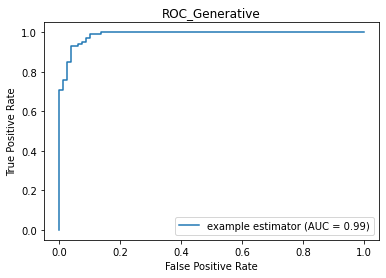

In [528]:
#Gaussian generative

#equ 4.73
p1 = c1_num/num

u1,S1 = mV(x1)
u2,S2 = mV(x2)

#4.78 cov S
S = c1_num*S1/num + c2_num*S2/num

#4.66 4.67 weight w bias w0
w = np.linalg.inv(S) @ (u1-u2)
w0 = 0.5*(u1.T @ np.linalg.inv(S) @ u1 + u2.T @ np.linalg.inv(S) @ u2) + np.log(p1/(1-p1))

#4.4 y
y_G1 = w.T @ x1 + w0
y_G2 = w.T @ x2 + w0

y_proba = np.concatenate((y_G1,y_G2)).flatten()
y_true = np.concatenate((np.ones(np.shape(y_G1)), np.zeros(np.shape(y_G2)))).flatten()
fpr, tpr, thresholds = metrics.roc_curve(y_true,y_proba)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()
plt.title("ROC_Generative")
plt.show()
# classify
count_1, x_G1,x_G2 = classifier(x1,[],[],y_G1)
count_2, x_G1,x_G2 = classifier(x2,x_G1,x_G2,y_G2)
x_G1 = np.array(x_G1)
x_G2 = np.array(x_G2)
#percent correct
perc = 100*(count_1[0]+count_2[1])/num

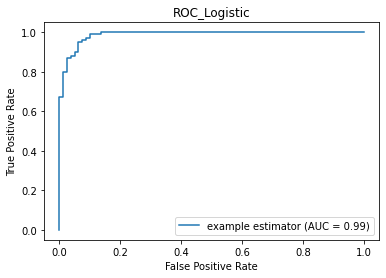

In [529]:
#Logistic regression
n_iters = 100
W = np.ones((2,1))

#count
for i in range(n_iters):
    oi = Iota(W,X)
    Y = np.squeeze((W.T@X),axis = 2)
    R = get_R(Y)
    T = (Y>0)
    z = oi @ W-np.linalg.inv(R) @ (Y-T)
    W = np.linalg.inv(oi.T @ R @ oi) @ oi.T @ R @ z

#equ 4.4
y_L1 = W.T@x1
y_L2 = W.T@x2

y_proba = np.concatenate((y_L1,y_L2)).flatten()
y_true = np.concatenate((np.ones(np.shape(y_L1)), np.zeros(np.shape(y_L2)))).flatten()
fpr, tpr, thresholds = metrics.roc_curve(y_true,y_proba)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()
plt.title("ROC_Logistic")
plt.show()

#classifier
count_1, x_L1,x_L2 = classifier(x1,[],[], y_L1)
count_2, x_L1,x_L2 = classifier(x2,x_L1,x_L2,y_L2)
x_L1,x_L2 = np.array(x_L1),np.array(x_L2)
#percent correct
perc2 = 100*(count_1[0]+count_2[1])/num

Text(3, 3, 'percent correct: 92.22%')

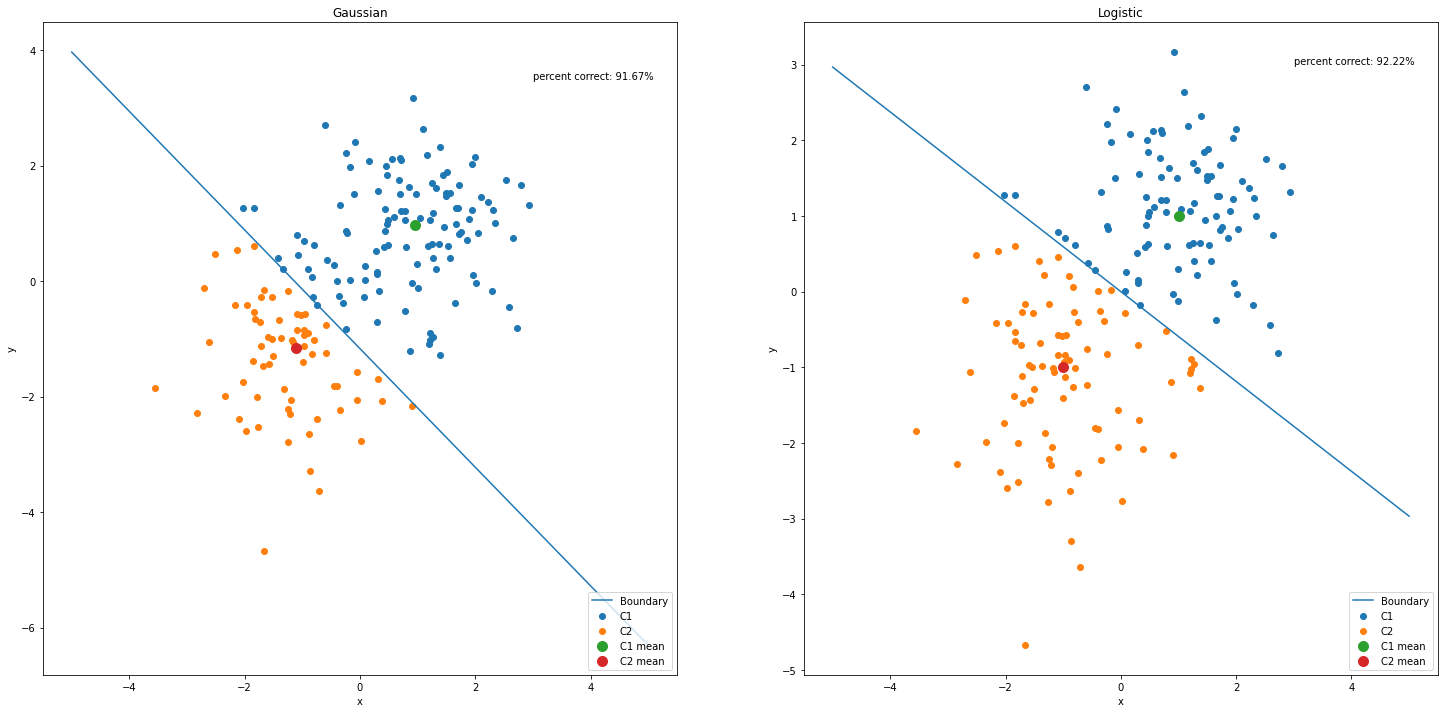

In [532]:
#get boundary
x = np.linspace(-5,5,100)
y1 = (-(w0+w.T[0][0]*x)/(w.T)[0][1]).T
y2 = (-W.T[0][0]*x/(W.T)[0][1]).T

f = plt.figure(figsize=(25,12))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

#plot for generative

ax.scatter(u1[0],u1[1],s = 100, label = "C1 mean")
ax.scatter(u2[0],u2[1],s = 100, label = "C2 mean")
ax.scatter(x_G1[:,0],x_G1[:,1],label = "C1")
ax.scatter(x_G2[:,0],x_G2[:,1],label = "C2")
ax.plot(x,y1,label = "Boundary")

ax.legend(loc =  'lower right')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Gaussian")
ax.text(3,3.5,'percent correct: %.2f%%' %perc)

#plot for logistic

ax2.scatter(Mu1[0],Mu1[1],s = 100, label = "C1 mean")
ax2.scatter(Mu2[0],Mu2[1],s = 100, label = "C2 mean")
ax2.scatter(x_L1[:,0],x_L1[:,1],label = "C1")
ax2.scatter(x_L2[:,0],x_L2[:,1],label = "C2")
ax2.plot(x,y2,label = "Boundary")

ax2.legend(loc = 'lower right')
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Logistic")
ax2.text(3,3,'percent correct: %.2f%%' %perc2)